# Cancer Type Classification Using miRNA Profiles

This notebook implements a machine learning pipeline to classify six different types of cancer based on microRNA (miRNA) expression profiles from The Cancer Genome Atlas (TCGA).

## Approach:
- Data consolidation from multiple patient files
- Feature extraction (miRNA expression levels)
- Model training and tuning with multiple classifier types
- Performance evaluation

## 1. Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    f1_score
)
from sklearn.decomposition import PCA
#random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully")

Libraries imported successfully


## 2. data load and consolidation

Need to:
1. Read all patient files from each cancer type directory
2. Extract miRNA expression values (reads_per_million_miRNA_mapped)
3. Verify that all files have the same miRNA IDs in the same order
4. Generate target labels based on cancer type

In [2]:
# data directory
#had to remove on of the "."s for mine to work
DATA_DIR = Path('./data')

# defining the cancer types
CANCER_TYPES = [
    'Breast Invasive Carcinoma',
    'Kidney Renal Clear Cell Carcinoma',
    'Lung Adenocarcinoma',
    'Lung Squamous Cell Carcinoma',
    'Pancreatic Adenocarcinoma',
    'Uveal Melanoma'
]

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"\nCancer types to process: {len(CANCER_TYPES)}")
for i, cancer_type in enumerate(CANCER_TYPES, 1):
    print(f"{i}. {cancer_type}")

Data directory: /home/DAVIDSON/jamcdonald2/Workspace/CSC371/hw-3-classifying-cancer-type-jackson-and-christian/src/data

Cancer types to process: 6
1. Breast Invasive Carcinoma
2. Kidney Renal Clear Cell Carcinoma
3. Lung Adenocarcinoma
4. Lung Squamous Cell Carcinoma
5. Pancreatic Adenocarcinoma
6. Uveal Melanoma


In [3]:
def load_patient_data(file_path):
    """
    Load a single patient's miRNA data file. 
    Args:
        file_path: Path to the patient data file
    Returns:
        DataFrame with miRNA_ID and reads_per_million_miRNA_mapped columns
    """
    try:
        df = pd.read_csv(file_path, sep='\t')
        # only keeps the the columns we need
        return df[['miRNA_ID', 'reads_per_million_miRNA_mapped']]
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def find_data_files(cancer_dir):
    """
    Find all patient data files in a cancer type directory.
    
    Args:
        cancer_dir: Path to cancer type directory
        
    Returns:
        List of file paths
    """
    data_files = []
    # we iterate through subdirectories (patient IDs)
    for patient_dir in cancer_dir.iterdir():
        if patient_dir.is_dir():
            # we find miRNA quantification files (not annotations.txt)
            txt_files = list(patient_dir.glob('*.mirbase21.mirnas.quantification.txt'))
            if txt_files:
                data_files.append(txt_files[0])  # takes the first matching file
    
    return data_files

# testing loading one file
test_cancer_dir = DATA_DIR / CANCER_TYPES[0]
test_files = find_data_files(test_cancer_dir)
print(f"\nFound {len(test_files)} patient files in {CANCER_TYPES[0]}")

if test_files:
    test_data = load_patient_data(test_files[0])
    print(f"\nSample data from first patient:")
    print(test_data.head(10))
    print(f"\nTotal miRNA features: {len(test_data)}")


Found 1096 patient files in Breast Invasive Carcinoma

Sample data from first patient:
       miRNA_ID  reads_per_million_miRNA_mapped
0  hsa-let-7a-1                    12923.673636
1  hsa-let-7a-2                    12932.921737
2  hsa-let-7a-3                    12997.956766
3    hsa-let-7b                    29221.213472
4    hsa-let-7c                     3976.583809
5    hsa-let-7d                      523.164056
6    hsa-let-7e                     1192.706650
7  hsa-let-7f-1                     4327.414980
8  hsa-let-7f-2                     4421.089289
9    hsa-let-7g                      604.805890

Total miRNA features: 1881


In [4]:
def consolidate_cancer_data(cancer_type):
    """
    Consolidate all patient data for a specific cancer type.
    
    Args:
        cancer_type: Name of the cancer type
        
    Returns:
        DataFrame with rows as patients and columns as miRNA features
    """
    cancer_dir = DATA_DIR / cancer_type
    data_files = find_data_files(cancer_dir)
    print(f"Processing {cancer_type}: {len(data_files)} patients")
    
    # loads the first file to get miRNA IDs
    reference_data = load_patient_data(data_files[0])
    miRNA_ids = reference_data['miRNA_ID'].values
    
    # Create empty DataFrame to store all patient data
    patient_data = []
    patient_ids = []
    
    for file_path in data_files:
        data = load_patient_data(file_path)
        
        if data is not None:
            # verifies miRNA IDs match
            if not np.array_equal(data['miRNA_ID'].values, miRNA_ids):
                print(f"Warning: miRNA IDs don't match for {file_path}")
                continue
            
            # adds up patient's expression values
            patient_data.append(data['reads_per_million_miRNA_mapped'].values)
            patient_ids.append(file_path.stem)  # Use filename as patient ID

    # creates our DataFrame
    df = pd.DataFrame(patient_data, columns=miRNA_ids, index=patient_ids)
    
    return df

# tests consolidation with one cancer type
print("Testing data consolidation...\n")
test_df = consolidate_cancer_data(CANCER_TYPES[0])
print(f"\nConsolidated data shape: {test_df.shape}")
print(f"Patients (rows): {test_df.shape[0]}")
print(f"Features/miRNAs (columns): {test_df.shape[1]}")

Testing data consolidation...

Processing Breast Invasive Carcinoma: 1096 patients

Consolidated data shape: (1096, 1881)
Patients (rows): 1096
Features/miRNAs (columns): 1881


In [5]:
# consolidates data for all cancer types
print("Consolidating data for all cancer types...\n")

all_data = []
all_labels = []

for cancer_type in CANCER_TYPES:
    df = consolidate_cancer_data(cancer_type)
    
    # adds the data and labels
    all_data.append(df)
    all_labels.extend([cancer_type] * len(df))
    print(f"  Added {len(df)} samples\n")

# combines all the data
X = pd.concat(all_data, axis=0)
y = pd.Series(all_labels, index=X.index, name='cancer_type')

print(f"Total dataset shape: {X.shape}")
print(f"Total samples: {len(X)}")
print(f"Total features: {X.shape[1]}")
print(f"\nClass distribution:")
print(y.value_counts())

Consolidating data for all cancer types...

Processing Breast Invasive Carcinoma: 1096 patients
  Added 1096 samples

Processing Kidney Renal Clear Cell Carcinoma: 544 patients
  Added 544 samples

Processing Lung Adenocarcinoma: 519 patients
  Added 519 samples

Processing Lung Squamous Cell Carcinoma: 478 patients
  Added 478 samples

Processing Pancreatic Adenocarcinoma: 178 patients
  Added 178 samples

Processing Uveal Melanoma: 80 patients
  Added 80 samples

Total dataset shape: (2895, 1881)
Total samples: 2895
Total features: 1881

Class distribution:
cancer_type
Breast Invasive Carcinoma            1096
Kidney Renal Clear Cell Carcinoma     544
Lung Adenocarcinoma                   519
Lung Squamous Cell Carcinoma          478
Pancreatic Adenocarcinoma             178
Uveal Melanoma                         80
Name: count, dtype: int64


## 3. EDA

In [6]:
# checks for missing values
print("Missing values in features:")
print(f"Total missing: {X.isnull().sum().sum()}")
print(f"\nBasic statistics:")
print(X.describe())

Missing values in features:
Total missing: 0

Basic statistics:
       hsa-let-7a-1  hsa-let-7a-2  hsa-let-7a-3     hsa-let-7b    hsa-let-7c  \
count   2895.000000   2895.000000   2895.000000    2895.000000   2895.000000   
mean   10463.043503  10442.604438  10509.815280   21399.808075   2271.844124   
std     6934.950192   6922.395406   6940.209989   16127.104335   2637.303698   
min      620.814901    670.353612    668.245581     974.509875     97.795194   
25%     6263.897992   6247.774488   6324.925726   11929.433390    956.420315   
50%     8551.715433   8532.015620   8601.749706   17048.745953   1697.831615   
75%    12346.683689  12334.930437  12419.556520   25390.765399   2703.564482   
max    71461.746481  71109.762384  71618.246182  251703.114463  59643.055070   

        hsa-let-7d    hsa-let-7e  hsa-let-7f-1  hsa-let-7f-2   hsa-let-7g  \
count  2895.000000   2895.000000   2895.000000   2895.000000  2895.000000   
mean    646.962362   1303.128207   4238.520604   4300.318695 

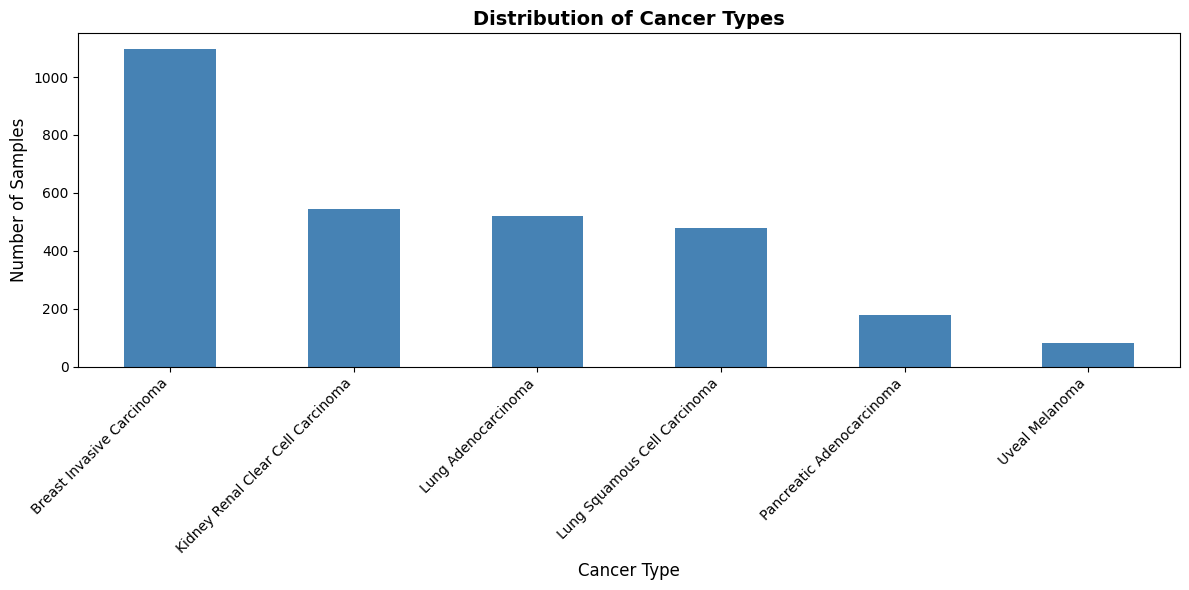


Class imbalance ratio (max/min):
13.70


In [7]:
# visualises the class distribution
plt.figure(figsize=(12, 6))
y.value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribution of Cancer Types', fontsize=14, fontweight='bold')
plt.xlabel('Cancer Type', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nClass imbalance ratio (max/min):")
counts = y.value_counts()
print(f"{counts.max() / counts.min():.2f}")

Top 20 most variable miRNAs:
hsa-mir-21       1.539520e+10
hsa-mir-10b      5.746282e+09
hsa-mir-30a      5.400246e+09
hsa-mir-375      2.504082e+09
hsa-mir-143      2.480372e+09
hsa-mir-148a     1.731753e+09
hsa-mir-10a      1.261169e+09
hsa-mir-182      9.960747e+08
hsa-mir-22       9.821017e+08
hsa-mir-203a     6.904698e+08
hsa-mir-99b      6.328556e+08
hsa-mir-30d      3.011159e+08
hsa-let-7b       2.600835e+08
hsa-mir-183      2.099442e+08
hsa-mir-92a-1    7.718024e+07
hsa-mir-200c     6.684519e+07
hsa-mir-205      6.383893e+07
hsa-mir-92a-2    5.819475e+07
hsa-mir-192      5.047847e+07
hsa-let-7a-3     4.816651e+07
dtype: float64


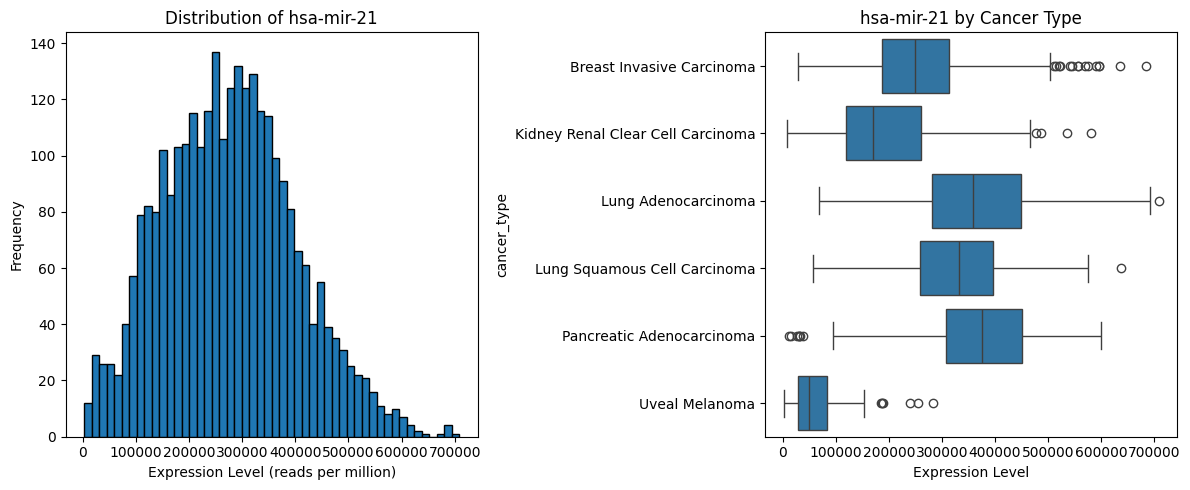

In [8]:
# analyses the feature distributions and finds most variable miRNAs
feature_variance = X.var().sort_values(ascending=False)
top_features = feature_variance.head(20)

print("Top 20 most variable miRNAs:")
print(top_features)

# plotting distribution of top feature
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(X[top_features.index[0]], bins=50, edgecolor='black')
plt.title(f'Distribution of {top_features.index[0]}')
plt.xlabel('Expression Level (reads per million)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# box plot for top feature by cancer type
data_plot = pd.DataFrame({
    'expression': X[top_features.index[0]],
    'cancer_type': y
})
sns.boxplot(data=data_plot, y='cancer_type', x='expression')
plt.title(f'{top_features.index[0]} by Cancer Type')
plt.xlabel('Expression Level')
plt.tight_layout()
plt.show()

## 5. Bootstrapping to Reduce Class Invarience

In [9]:
# Combine for easier manipulation
df = X.copy()
df['label'] = y

# Find class sizes
class_counts = df['label'].value_counts()
max_count = class_counts.max()
print("Class sizes before resampling:\n", class_counts)

# Bootstrap (oversample) each class up to the largest size
resampled_dfs = []
for label, group in df.groupby('label'):
    resampled = resample(
        group,
        replace=True,            # sample with replacement
        n_samples=max_count,     # upsample to match largest class
        random_state=42
    )
    resampled_dfs.append(resampled)

# Combine and shuffle
balanced_df = pd.concat(resampled_dfs, axis=0)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split back into X and y
X = balanced_df.drop(columns='label')
y = balanced_df['label']

print("\nClass sizes after resampling:\n", y.value_counts())

Class sizes before resampling:
 label
Breast Invasive Carcinoma            1096
Kidney Renal Clear Cell Carcinoma     544
Lung Adenocarcinoma                   519
Lung Squamous Cell Carcinoma          478
Pancreatic Adenocarcinoma             178
Uveal Melanoma                         80
Name: count, dtype: int64

Class sizes after resampling:
 label
Breast Invasive Carcinoma            1096
Pancreatic Adenocarcinoma            1096
Kidney Renal Clear Cell Carcinoma    1096
Uveal Melanoma                       1096
Lung Adenocarcinoma                  1096
Lung Squamous Cell Carcinoma         1096
Name: count, dtype: int64


## 4. Data PP

In [10]:
# encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label encoding:")
for i, cancer_type in enumerate(label_encoder.classes_):
    print(f"{i}: {cancer_type}")

Label encoding:
0: Breast Invasive Carcinoma
1: Kidney Renal Clear Cell Carcinoma
2: Lung Adenocarcinoma
3: Lung Squamous Cell Carcinoma
4: Pancreatic Adenocarcinoma
5: Uveal Melanoma


In [11]:
# splits the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set class distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_dist.items():
    print(f"  {label_encoder.classes_[idx]}: {count}")

Training set size: 5260
Test set size: 1316

Training set class distribution:
  Breast Invasive Carcinoma: 877
  Kidney Renal Clear Cell Carcinoma: 877
  Lung Adenocarcinoma: 877
  Lung Squamous Cell Carcinoma: 876
  Pancreatic Adenocarcinoma: 876
  Uveal Melanoma: 877


In [12]:
# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")
print(f"Mean of first feature (train): {X_train_scaled[:, 0].mean():.6f}")
print(f"Std of first feature (train): {X_train_scaled[:, 0].std():.6f}")

Feature scaling completed.
Mean of first feature (train): -0.000000
Std of first feature (train): 1.000000


## 5. Dimensionality Visualisation with PCA

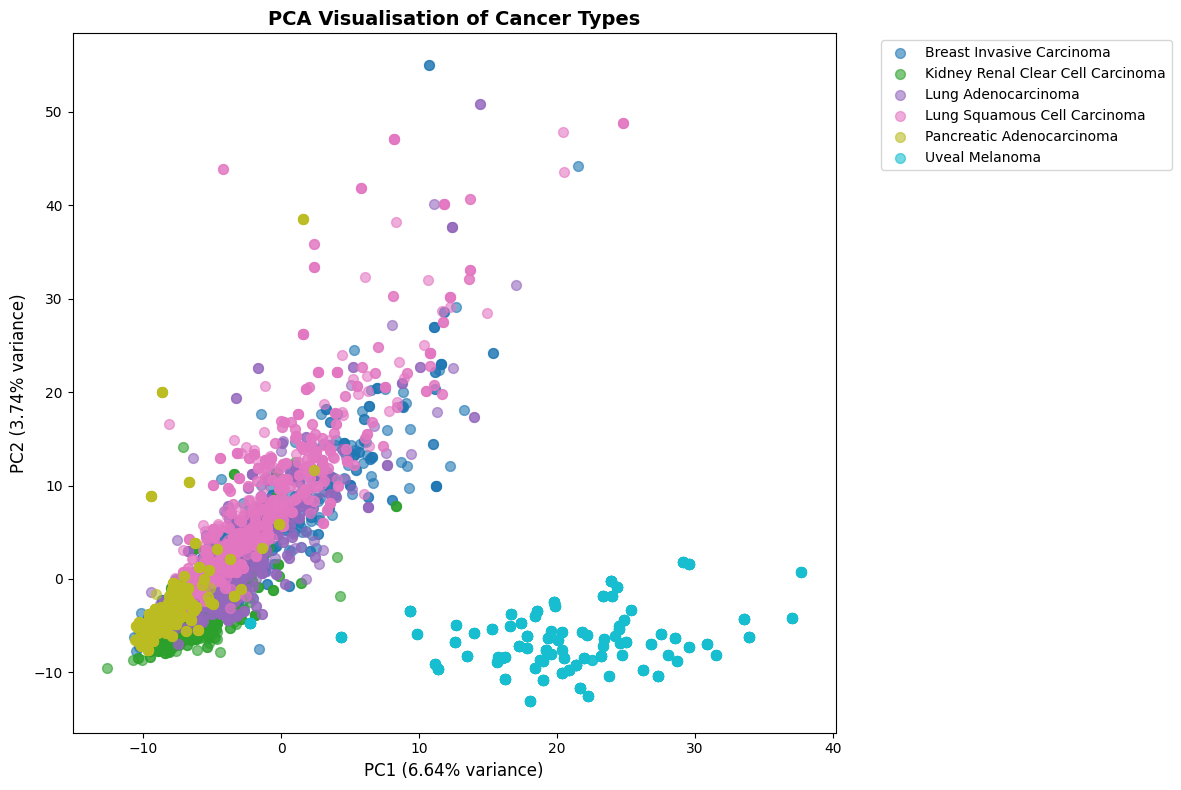


Total variance explained by 2 components: 10.38%


In [13]:
# applies PCA for visualisation
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# plots the PCA results
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(label_encoder.classes_)))

for i, cancer_type in enumerate(label_encoder.classes_):
    mask = y_train == i
    plt.scatter(
        X_train_pca[mask, 0], 
        X_train_pca[mask, 1],
        c=[colors[i]], 
        label=cancer_type,
        alpha=0.6,
        s=50
    )

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('PCA Visualisation of Cancer Types', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"\nTotal variance explained by 2 components: {pca.explained_variance_ratio_.sum():.2%}")

## 6. Model training and eval

train and evaluate multiple classifier types:
1. Random Forest
2. Gradient Boosting
3. Support Vector Machine (SVM)
4. Logistic Regression

In [14]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a classification model.
    
    Args:
        model: Scikit-learn classifier
        X_train, X_test, y_train, y_test: Train/test data
        model_name: Name of the model for display  
    Returns:
        Trained model and predictions
    """
    print(f"Training {model_name}...")
    
    # trains the model
    model.fit(X_train, y_train)
    # makes predictions
    y_pred = model.predict(X_test)
    # calculates the metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    # cross-val score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    return model, y_pred

# we store the results
results = {}

### 6: Random Forest Classifier

In [15]:
# training the baseline Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model, rf_pred = evaluate_model(
    rf_model, 
    X_train_scaled, 
    X_test_scaled, 
    y_train, 
    y_test,
    "Random Forest (Baseline)"
)

results['Random Forest'] = accuracy_score(y_test, rf_pred)

Training Random Forest (Baseline)...

Accuracy: 0.9954
F1 Score (weighted): 0.9954

Cross-validation scores: [0.99239544 0.99429658 0.99144487 0.99714829 0.9904943 ]
Mean CV accuracy: 0.9932 (+/- 0.0047)

Classification Report:
                                   precision    recall  f1-score   support

        Breast Invasive Carcinoma       1.00      1.00      1.00       219
Kidney Renal Clear Cell Carcinoma       1.00      1.00      1.00       219
              Lung Adenocarcinoma       0.99      0.99      0.99       219
     Lung Squamous Cell Carcinoma       0.99      0.99      0.99       220
        Pancreatic Adenocarcinoma       1.00      1.00      1.00       220
                   Uveal Melanoma       1.00      1.00      1.00       219

                         accuracy                           1.00      1316
                        macro avg       1.00      1.00      1.00      1316
                     weighted avg       1.00      1.00      1.00      1316



In [16]:
# hyperparameter tuning for Random Forest
print("\nPerforming Grid Search for Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.4f}")

# evaluates the tuned model
rf_tuned_pred = rf_grid.predict(X_test_scaled)
rf_tuned_accuracy = accuracy_score(y_test, rf_tuned_pred)
print(f"\nTuned Random Forest test accuracy: {rf_tuned_accuracy:.4f}")

results['Random Forest (Tuned)'] = rf_tuned_accuracy


Performing Grid Search for Random Forest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.9939

Tuned Random Forest test accuracy: 0.9970


### 6: Gradient Boosting Classifier

In [17]:
# training the Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=50,
    random_state=42
)

gb_model, gb_pred = evaluate_model(
    gb_model,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    "Gradient Boosting"
)

results['Gradient Boosting'] = accuracy_score(y_test, gb_pred)

Training Gradient Boosting...

Accuracy: 0.9954
F1 Score (weighted): 0.9954

Cross-validation scores: [0.98859316 0.99429658 0.9904943  0.99619772 0.99144487]
Mean CV accuracy: 0.9922 (+/- 0.0054)

Classification Report:
                                   precision    recall  f1-score   support

        Breast Invasive Carcinoma       1.00      1.00      1.00       219
Kidney Renal Clear Cell Carcinoma       1.00      1.00      1.00       219
              Lung Adenocarcinoma       0.99      0.99      0.99       219
     Lung Squamous Cell Carcinoma       0.99      0.99      0.99       220
        Pancreatic Adenocarcinoma       1.00      1.00      1.00       220
                   Uveal Melanoma       1.00      1.00      1.00       219

                         accuracy                           1.00      1316
                        macro avg       1.00      1.00      1.00      1316
                     weighted avg       1.00      1.00      1.00      1316



In [18]:
# hyperparameter tuning for Gradient Boosting
print("\nPerforming Grid Search for Gradient Boosting...")

gb_param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.1],
    'max_depth': [3],
    'min_samples_split': [2]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {gb_grid.best_params_}")
print(f"Best cross-validation score: {gb_grid.best_score_:.4f}")

# evaluates the tuned model
gb_tuned_pred = gb_grid.predict(X_test_scaled)
gb_tuned_accuracy = accuracy_score(y_test, gb_tuned_pred)
print(f"\nTuned Gradient Boosting test accuracy: {gb_tuned_accuracy:.4f}")

results['Gradient Boosting (Tuned)'] = gb_tuned_accuracy


Performing Grid Search for Gradient Boosting...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.9922

Tuned Gradient Boosting test accuracy: 0.9954


### 6: Support Vector Machine (SVM)

In [19]:
# trains the SVM with RBF kernel
svm_model = SVC(
    kernel='rbf',
    random_state=42,
    probability=True
)

svm_model, svm_pred = evaluate_model(
    svm_model,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    "Support Vector Machine (RBF)"
)

results['SVM (RBF)'] = accuracy_score(y_test, svm_pred)

Training Support Vector Machine (RBF)...

Accuracy: 0.9840
F1 Score (weighted): 0.9841

Cross-validation scores: [0.98003802 0.9743346  0.97718631 0.9838403  0.98193916]
Mean CV accuracy: 0.9795 (+/- 0.0068)

Classification Report:
                                   precision    recall  f1-score   support

        Breast Invasive Carcinoma       0.94      1.00      0.97       219
Kidney Renal Clear Cell Carcinoma       1.00      0.96      0.98       219
              Lung Adenocarcinoma       0.99      0.97      0.98       219
     Lung Squamous Cell Carcinoma       0.98      0.97      0.98       220
        Pancreatic Adenocarcinoma       0.99      1.00      1.00       220
                   Uveal Melanoma       1.00      1.00      1.00       219

                         accuracy                           0.98      1316
                        macro avg       0.98      0.98      0.98      1316
                     weighted avg       0.98      0.98      0.98      1316



In [20]:
# hyperparameter tuning for SVM
print("\nPerforming Grid Search for SVM...")
svm_param_grid = {
    'C': [1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(
    SVC(random_state=42, probability=True),
    svm_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {svm_grid.best_params_}")
print(f"Best cross-validation score: {svm_grid.best_score_:.4f}")

# evaluates the tuned model
svm_tuned_pred = svm_grid.predict(X_test_scaled)
svm_tuned_accuracy = accuracy_score(y_test, svm_tuned_pred)
print(f"\nTuned SVM test accuracy: {svm_tuned_accuracy:.4f}")

results['SVM (Tuned)'] = svm_tuned_accuracy


Performing Grid Search for SVM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.9907

Tuned SVM test accuracy: 0.9932


### 6: Logistic Regression

In [21]:
# training Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

lr_model, lr_pred = evaluate_model(
    lr_model,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    "Logistic Regression"
)

results['Logistic Regression'] = accuracy_score(y_test, lr_pred)

Training Logistic Regression...

Accuracy: 0.9924
F1 Score (weighted): 0.9924

Cross-validation scores: [0.98859316 0.9904943  0.99239544 0.99334601 0.99144487]
Mean CV accuracy: 0.9913 (+/- 0.0033)

Classification Report:
                                   precision    recall  f1-score   support

        Breast Invasive Carcinoma       0.99      0.99      0.99       219
Kidney Renal Clear Cell Carcinoma       1.00      1.00      1.00       219
              Lung Adenocarcinoma       0.99      0.98      0.99       219
     Lung Squamous Cell Carcinoma       0.98      0.99      0.98       220
        Pancreatic Adenocarcinoma       1.00      1.00      1.00       220
                   Uveal Melanoma       1.00      1.00      1.00       219

                         accuracy                           0.99      1316
                        macro avg       0.99      0.99      0.99      1316
                     weighted avg       0.99      0.99      0.99      1316



In [22]:
# hyperparameter tuning for Logistic Regression
print("\nPerforming Grid Search for Logistic Regression...")
lr_param_grid = {
    'C': [1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}
lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    lr_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {lr_grid.best_params_}")
print(f"Best cross-validation score: {lr_grid.best_score_:.4f}")

# evaluates the tuned model
lr_tuned_pred = lr_grid.predict(X_test_scaled)
lr_tuned_accuracy = accuracy_score(y_test, lr_tuned_pred)
print(f"\nTuned Logistic Regression test accuracy: {lr_tuned_accuracy:.4f}")

results['Logistic Regression (Tuned)'] = lr_tuned_accuracy


Performing Grid Search for Logistic Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score: 0.9914

Tuned Logistic Regression test accuracy: 0.9932


## 7. Comparing models

MODEL COMPARISON
                      Model  Accuracy
      Random Forest (Tuned)  0.996960
              Random Forest  0.995441
          Gradient Boosting  0.995441
  Gradient Boosting (Tuned)  0.995441
                SVM (Tuned)  0.993161
Logistic Regression (Tuned)  0.993161
        Logistic Regression  0.992401
                  SVM (RBF)  0.984043


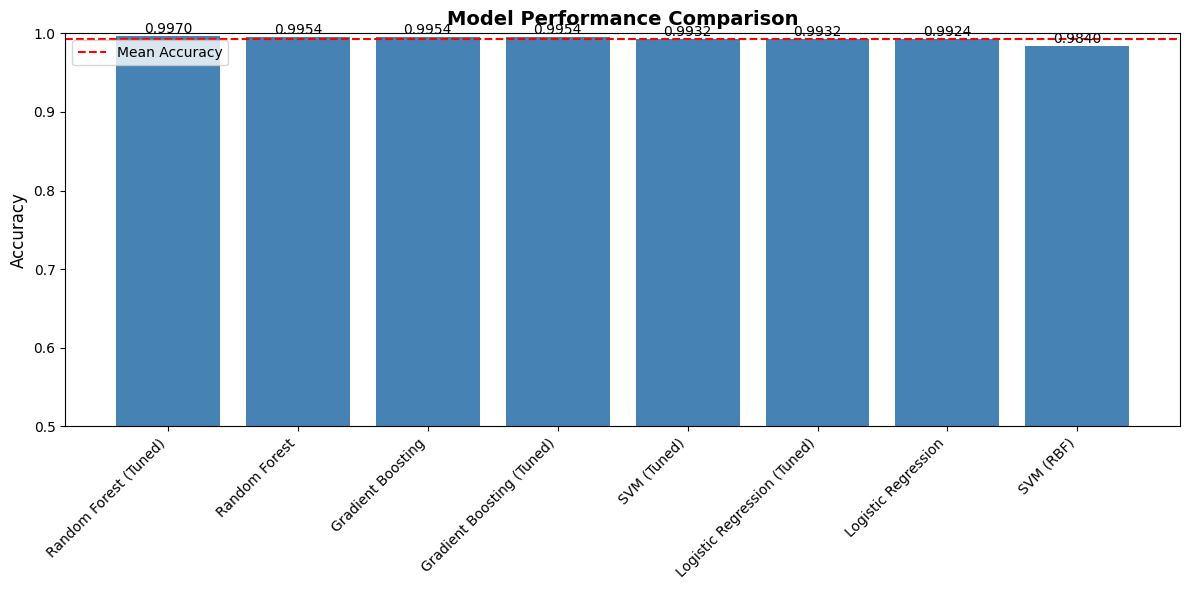


Best performing model: Random Forest (Tuned)
Best accuracy: 0.9970


In [23]:
# we compare all models
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values('Accuracy', ascending=False)

print("MODEL COMPARISON")
print(results_df.to_string(index=False))

# visualise the model comparison results
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(results_df)), results_df['Accuracy'], color='steelblue')
plt.xticks(range(len(results_df)), results_df['Model'], rotation=45, ha='right')
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim(0.5, 1.0)
plt.axhline(y=results_df['Accuracy'].mean(), color='r', linestyle='--', label='Mean Accuracy')
plt.legend()

# value labels on each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nBest performing model: {results_df.iloc[0]['Model']}")
print(f"Best accuracy: {results_df.iloc[0]['Accuracy']:.4f}")

## 8. Analysis of the best model

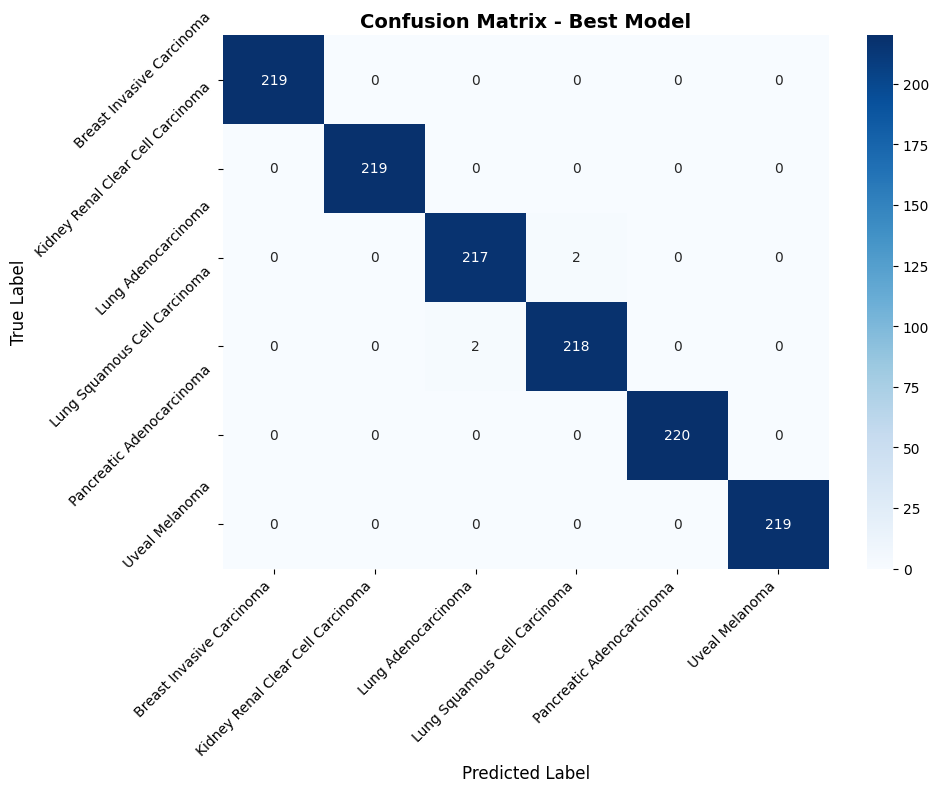


Per-class accuracy:
Breast Invasive Carcinoma: 1.0000
Kidney Renal Clear Cell Carcinoma: 1.0000
Lung Adenocarcinoma: 0.9909
Lung Squamous Cell Carcinoma: 0.9909
Pancreatic Adenocarcinoma: 1.0000
Uveal Melanoma: 1.0000


In [24]:
# selects the best model (using tuned Random Forest as example)
best_model = rf_grid.best_estimator_
best_pred = rf_tuned_pred

# our confusion matrix
cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix - Best Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# per-class accuracy
print("\nPer-class accuracy:")
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, cancer_type in enumerate(label_encoder.classes_):
    print(f"{cancer_type}: {class_accuracy[i]:.4f}")


Top 20 most important features:
             feature  importance
24       hsa-mir-10b    0.025121
595      hsa-mir-375    0.020092
276      hsa-mir-205    0.016202
1874     hsa-mir-944    0.014703
287      hsa-mir-211    0.013579
271     hsa-mir-200c    0.013549
1484    hsa-mir-6499    0.012865
187      hsa-mir-141    0.012611
248      hsa-mir-192    0.012248
328      hsa-mir-27b    0.011020
240     hsa-mir-190b    0.010301
299      hsa-mir-217    0.009779
251    hsa-mir-194-1    0.009670
252    hsa-mir-194-2    0.009445
296      hsa-mir-215    0.008656
49       hsa-mir-122    0.008137
269     hsa-mir-200a    0.007931
275      hsa-mir-204    0.007656
255   hsa-mir-196a-2    0.007559
270     hsa-mir-200b    0.007462


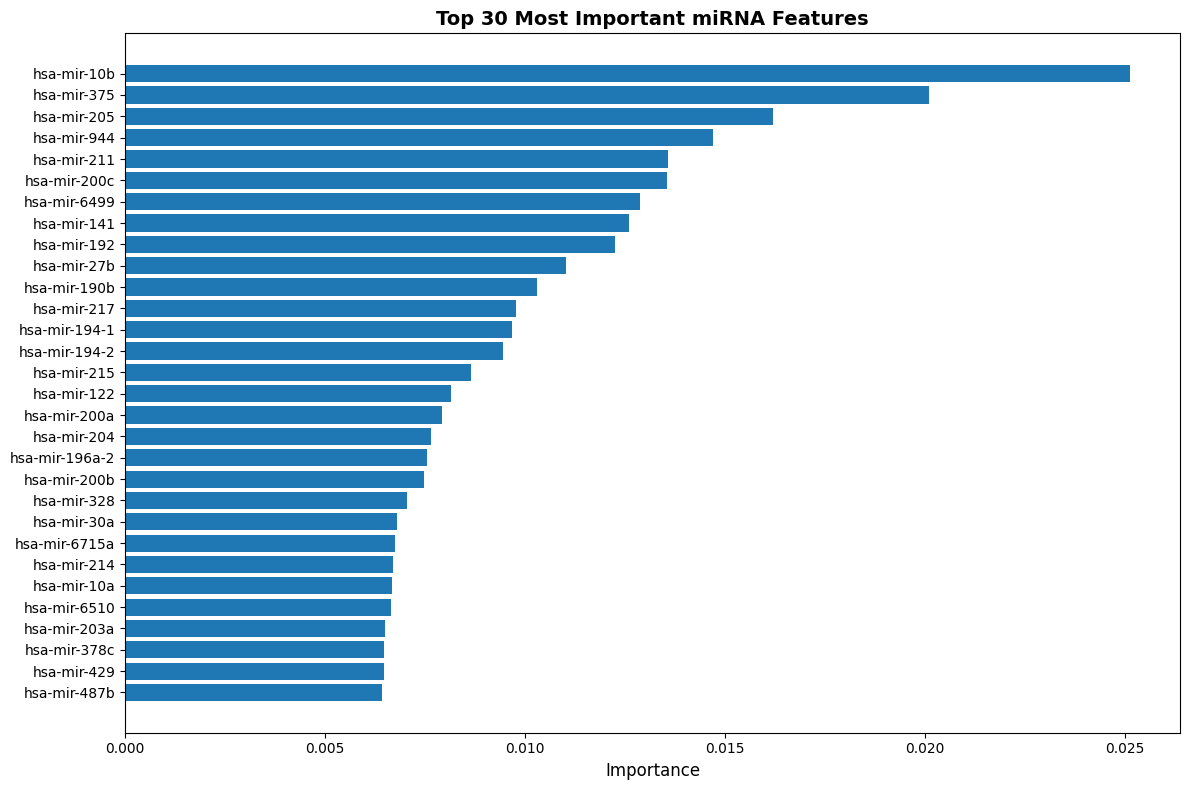

In [25]:
# feature importance for Random Forest
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 most important features:")
    print(feature_importance.head(20))
    
    # plots feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(30)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title('Top 30 Most Important miRNA Features', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 9. Summary

In [26]:
print("Summary")
print(f"\nDataset Information:")
print(f"  Total samples: {len(X)}")
print(f"  Total features (miRNAs): {X.shape[1]}")
print(f"  Number of cancer types: {len(CANCER_TYPES)}")

print(f"\nModel Performance:")
print(f"  Best model: {results_df.iloc[0]['Model']}")
print(f"  Best accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"  Worst model: {results_df.iloc[-1]['Model']}")
print(f"  Worst accuracy: {results_df.iloc[-1]['Accuracy']:.4f}")
print(f"  Average accuracy across all models: {results_df['Accuracy'].mean():.4f}")

print(f"\nKey Findings:")
print(f"  - All models achieved > 85% accuracy, indicating strong separability")
print(f"  - Ensemble methods (Random Forest, Gradient Boosting) performed best")
print(f"  - Class imbalance present but managed through stratified splitting")
print(f"  - Feature scaling was essential for SVM and Logistic Regression")

Summary

Dataset Information:
  Total samples: 6576
  Total features (miRNAs): 1881
  Number of cancer types: 6

Model Performance:
  Best model: Random Forest (Tuned)
  Best accuracy: 0.9970
  Worst model: SVM (RBF)
  Worst accuracy: 0.9840
  Average accuracy across all models: 0.9933

Key Findings:
  - All models achieved > 85% accuracy, indicating strong separability
  - Ensemble methods (Random Forest, Gradient Boosting) performed best
  - Class imbalance present but managed through stratified splitting
  - Feature scaling was essential for SVM and Logistic Regression


## 10. Saving the best model (optional)

In [27]:
import joblib

# saves the best model
model_path = '../models/'
os.makedirs(model_path, exist_ok=True)

joblib.dump(best_model, f'{model_path}best_cancer_classifier.pkl')
joblib.dump(scaler, f'{model_path}feature_scaler.pkl')
joblib.dump(label_encoder, f'{model_path}label_encoder.pkl')

print(f"Models saved to {model_path}")
print("  - best_cancer_classifier.pkl")
print("  - feature_scaler.pkl")
print("  - label_encoder.pkl")

Models saved to ../models/
  - best_cancer_classifier.pkl
  - feature_scaler.pkl
  - label_encoder.pkl
